In [41]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, words, wordnet
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("vader_lexicon")
nltk.download("words")
nltk.download("averaged_perceptron_tagger")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("omw-1.4")

english_vocab = set(words.words())
stop_words_eng = set(stopwords.words("english"))
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nlt

In [42]:
train_df = pd.read_csv('/content/train.csv', encoding='latin1')
test_df = pd.read_csv('/content/test.csv', encoding='latin1')

In [43]:
print(train_df.shape)
print(test_df.shape)

(27481, 10)
(4815, 9)


In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [45]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [46]:
train_df.drop(columns = {"textID","selected_text","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)",},inplace=True)

In [47]:
test_df.drop(columns = {"textID","Time of Tweet","Age of User","Country","Population -2020","Land Area (Km²)","Density (P/Km²)"},inplace=True)

In [48]:
test_df

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive
...,...,...
4810,NaN,NaN
4811,NaN,NaN
4812,NaN,NaN
4813,NaN,NaN


In [49]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [50]:
train_df.isnull().sum()

,0
text,1
sentiment,0


In [51]:
test_df.isnull().sum()

,0
text,1281
sentiment,1281


In [52]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [53]:
print(train_df.shape)
print(test_df.shape)

(27480, 2)
(3534, 2)


In [54]:
lemmatizer = WordNetLemmatizer()

In [55]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Bu fonksiyon, nltk.pos_tag() ile elde edilen POS (Part-of-Speech) etiketlerini WordNetLemmatizer ile uyumlu forma dönüştürür. Çünkü WordNetLemmatizer yalnızca wordnet.NOUN, wordnet.VERB, wordnet.ADJ ve wordnet.ADV türlerini kabul eder.

Etiket 'J' ile başlıyorsa sıfat (ADJ), 'V' ile başlıyorsa fiil (VERB), 'N' ile başlıyorsa isim (NOUN), 'R' ile başlıyorsa zarf (ADV) olarak döner. Diğer tüm durumlarda varsayılan olarak wordnet.NOUN döndürülür.

Bu sayede lemmatizasyon işlemi, kelimenin bağlamına uygun şekilde yapılabilir (örneğin "running" → "run").

In [56]:
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    text = re.sub("[^a-zA-Z]", " ", text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english") and len(word) > 2]
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tag(words)]
    return " ".join(words)

Bu fonksiyon, verilen metni doğal dil işleme için temizler.
Metni küçük harfe çevirir, kısaltmaları açar, HTML etiketlerini ve URL’leri kaldırır, sadece harfleri bırakır.
Ardından, stopword'leri (gereksiz kelimeleri) filtreler, kelimeleri köklerine (lemma) indirger.

In [57]:
cleaned_text = [clean_text(word) for word in train_df["text"]]

List comprehension yöntemi ile df["text"] sütununa clean_text fonksiyonu uygulanır.

In [58]:
train_df["cleaned_text"] = cleaned_text

Ardından temizlenmiş texti cleaned_text olarak train_df'e kaydederiz.

In [59]:
train_df = train_df[train_df["cleaned_text"].str.strip() != ""].copy()

Bu satırın yaptığı işlem, boş (ya da sadece boşluklardan oluşan) "cleaned_text" hücrelerini veri setinden temizlemektir.

In [60]:
train_df

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",neutral,respond go
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bully
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,son put release already buy
...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,wish could come see denver husband lose job af...
27477,I`ve wondered about rake to. The client has ...,negative,wonder rake client make clear net force devs l...
27478,Yay good for both of you. Enjoy the break - y...,positive,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,positive,worth


In [61]:
for i in range(5):
  print("Original text:",train_df.loc[i,"text"])
  print("Cleaned text: ",train_df.loc[i,"cleaned_text"])
  print("")

Original text:  I`d have responded, if I were going
Cleaned text:  respond go

Original text:  Sooo SAD I will miss you here in San Diego!!!
Cleaned text:  sooo sad miss san diego

Original text: my boss is bullying me...
Cleaned text:  bos bully

Original text:  what interview! leave me alone
Cleaned text:  interview leave alone

Original text:  Sons of ****, why couldn`t they put them on the releases we already bought
Cleaned text:  son put release already buy



In [62]:
le = LabelEncoder()
train_df["sentiment"] = le.fit_transform(train_df["sentiment"])
train_df.head()

,text,sentiment,cleaned_text
0,"I`d have responded, if I were going",1,respond go
1,Sooo SAD I will miss you here in San Diego!!!,0,sooo sad miss san diego
2,my boss is bullying me...,0,bos bully
3,what interview! leave me alone,0,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",0,son put release already buy


Bu kod bloğu, metin şeklindeki duygu (sentiment) etiketlerini sayısal değerlere dönüştürür.

In [63]:
train_df["sentiment"].value_counts()

,count
sentiment,
1,11011
2,8578
0,7773


In [64]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # max skora göre sınıf ata
    max_label = max(scores, key=lambda k: scores[k] if k in ["neg", "neu", "pos"] else -1)

    if max_label == "neg":
        return 0
    elif max_label == "neu":
        return 1
    else:
        return 2

Bu fonksiyon, elindeki metni alıyor ve onun pozitif mi, negatif mi yoksa nötr mü olduğunu VADER isimli bir analiz aracıyla değerlendiriyor. Bu araç, metnin içinde pozitif, negatif ve nötr duygulara puanlar veriyor. Fonksiyon da bu puanlara bakıp en yüksek olan duygu türünü seçiyor ve ona göre 0, 1 ya da 2 şeklinde bir sayı döndürüyor. Yani metnin en baskın duygu türünü sayısal olarak bize söylüyor. Böylece bu sayıyı makine öğrenmesi modellerinde kullanabiliyoruz.

In [65]:
train_df["sentiment_new"] = train_df["cleaned_text"].apply(get_sentiment)

get_sentiment fonksiyonunu train_df["cleaned_text"] üzerinde apply fonksiyonunu  kullanarak uygulayıp bunu train_df["sentiment_new"] ' a atıyoruz.

In [66]:
train_df

,text,sentiment,cleaned_text,sentiment_new
0,"I`d have responded, if I were going",1,respond go,1
1,Sooo SAD I will miss you here in San Diego!!!,0,sooo sad miss san diego,0
2,my boss is bullying me...,0,bos bully,0
3,what interview! leave me alone,0,interview leave alone,0
4,"Sons of ****, why couldn`t they put them on t...",0,son put release already buy,1
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,0,wish could come see denver husband lose job af...,1
27477,I`ve wondered about rake to. The client has ...,0,wonder rake client make clear net force devs l...,1
27478,Yay good for both of you. Enjoy the break - y...,2,yay good enjoy break probably need hectic week...,2
27479,But it was worth it ****.,2,worth,2


0 : negative


1 : neutral  


2 : positive


In [67]:
test_df["cleaned_text"] = test_df["text"].apply(clean_text)
test_df["sentiment"] = le.fit_transform(test_df["sentiment"])
test_df["sentiment_new"] = test_df["cleaned_text"].apply(get_sentiment)
test_df.head()

,text,sentiment,cleaned_text,sentiment_new
0,Last session of the day http://twitpic.com/67ezh,1,last session day,1
1,Shanghai is also really exciting (precisely -...,2,shanghai also really excite precisely skyscrap...,1
2,"Recession hit Veronique Branquinho, she has to...",0,recession hit veronique branquinho quit compan...,0
3,happy bday!,2,happy birthday,2
4,http://twitpic.com/4w75p - I like it!!,2,like,2


test_df üzerinde de aynı işlemler uygulanıyor.

In [69]:
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier()]
model_names = ["LogisticRegression()","DecisionTreeClassifier","RandomForestClassifier","GradientBoostingClassifier"]
vectorizers = [TfidfVectorizer,CountVectorizer]
vectorizer_names = ["CountVectorizer", "TfidfVectorizer"]

In [70]:
def choose():
    scores = {}
    y_preds = {}

    for i, model in enumerate(models):
        for j, vectorizer_class in enumerate(vectorizers):
            vectorizer = vectorizer_class(max_features=5000)
            X_train = vectorizer.fit_transform(train_df["cleaned_text"])
            X_test = vectorizer.transform(test_df["cleaned_text"])

            model.fit(X_train, train_df["sentiment_new"])
            y_pred = model.predict(X_test)

            acc = accuracy_score(test_df["sentiment_new"], y_pred)
            scores[(i, j)] = acc
            y_preds[(i, j)] = y_pred

    best_combo = max(scores, key=scores.get)
    best_score = scores[best_combo]
    best_pred = y_preds[best_combo]
    best_model_name = model_names[best_combo[0]]
    best_vectorizer_name = vectorizer_names[best_combo[1]]

    print("En iyi model:", best_model_name)
    print("En iyi vectorizer:", best_vectorizer_name)
    print("Accuracy:", round(best_score, 4))
    print("--------------------------------------")

    cm = confusion_matrix(test_df["sentiment_new"], best_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Confusion Matrix\n{best_model_name} + {best_vectorizer_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

Bu fonksiyon elimdeki farklı modeller ve vektörleştiricilerle denemeler yapıyor. Her ikisinin farklı kombinasyonlarını kullanarak önce modeli eğitiyor, sonra test verisi üzerinde tahmin yapıyor ve doğruluk oranını hesaplıyor.

Tüm kombinasyonlar içinde en yüksek doğruluk veren model ve vektörleştiriciyi bulup ekrana yazdırıyor. Ayrıca, bu en iyi modelin tahminlerine göre karışıklık matrisi çiziyor. Bu matris sayesinde modelin hangi sınıflarda iyi, nerelerde hata yaptığını görebiliyorum.

Yani, elimdeki seçenekler arasında en iyisini otomatik olarak seçip sonuçlarını gösteren bir fonksiyon.

En iyi model: LogisticRegression()
En iyi vectorizer: TfidfVectorizer
Accuracy: 0.8905
--------------------------------------


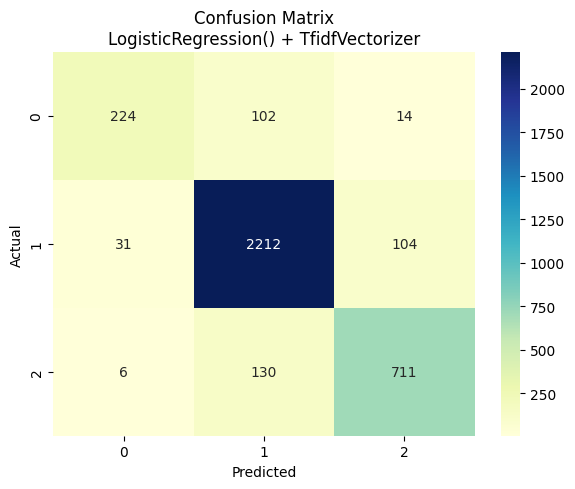

In [71]:
choose()